In [1]:
#### Multi-scale representation (MSR) or multiresolution analysis (MRA)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import MSR
import pywt # python wavlet
from filterbank import Steerable, visualize
import LogGabor

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext holoviews.ipython

In [2]:
#### read image data
imColor = cv2.imread('../wavelet/input.png')
#print(np.shape(imColor))
imGray = cv2.cvtColor(imColor, cv2.COLOR_BGR2GRAY)
print(np.shape(imGray))

(512, 512)


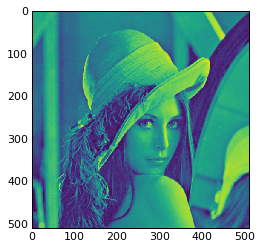

In [3]:
plt.figure()
plt.imshow(imGray)

In [4]:
#### Laplacian pyramid
level = 6

# generate image pyramid
gp = MSR.gaussian_pyr(imGray,level=6)    
lp = MSR.laplacian_pyr(imGray,level=6)

print('Gaussian pyramid')
for im in gp:
    print(np.shape(im))
print('Laplacian pyramid')
for im in lp:
    print(np.shape(im))

Gaussian pyramid
(512, 512)
(256, 256)
(128, 128)
(64, 64)
(32, 32)
(16, 16)
Laplacian pyramid
(512, 512)
(256, 256)
(128, 128)
(64, 64)
(32, 32)
(16, 16)


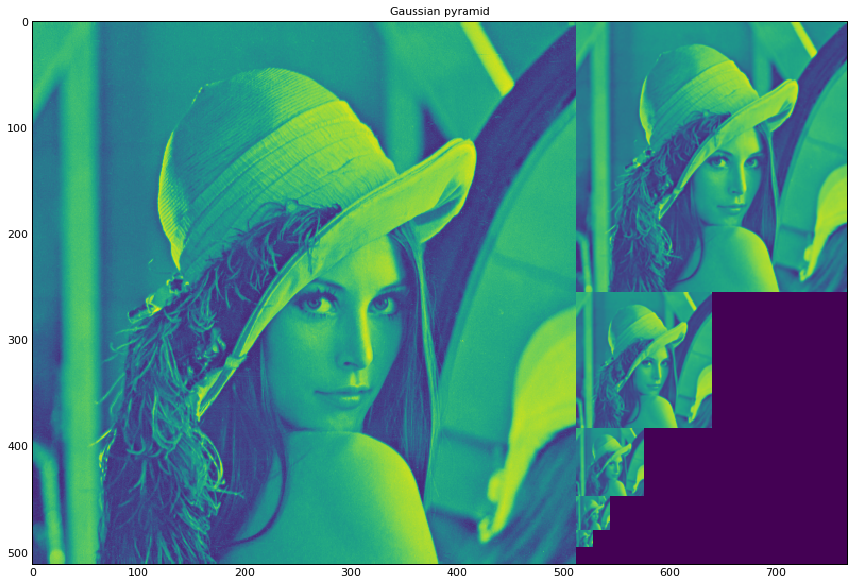

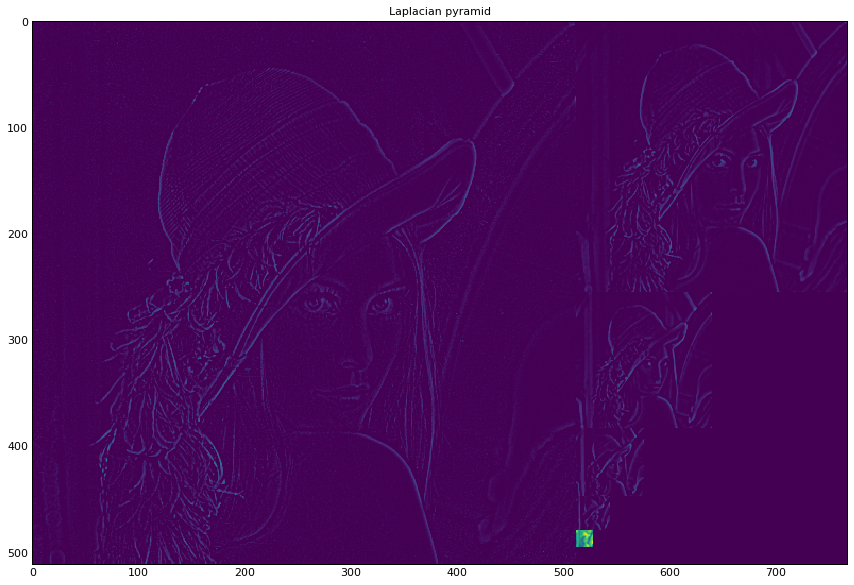

In [5]:
fig,axes = plt.subplots(figsize=(20,10))
axes.imshow(MSR.imPyrshow(gp))
plt.title('Gaussian pyramid')

fig,axes = plt.subplots(figsize=(20,10))
axes.imshow(MSR.imPyrshow(lp))
plt.title('Laplacian pyramid')

In [6]:
#### Separable orthogonal wavelet
wp = pywt.wavedec2(imGray,'db2',level=3)
for im in wp:
    print(np.shape(im))

(66, 66)
(3, 66, 66)
(3, 130, 130)
(3, 257, 257)


In [7]:
def normwt(coeffs):
    # normalize wavelet coeffs
    ncoeffs = [coeffs[0]/np.linalg.norm(coeffs[0])]
    for k in range(1,len(coeffs)):
        tmp = ()
        for l in range(3):
            tmp += (coeffs[k][l]/np.linalg.norm(coeffs[k][l]),)
        ncoeffs.append(tmp)

    return ncoeffs

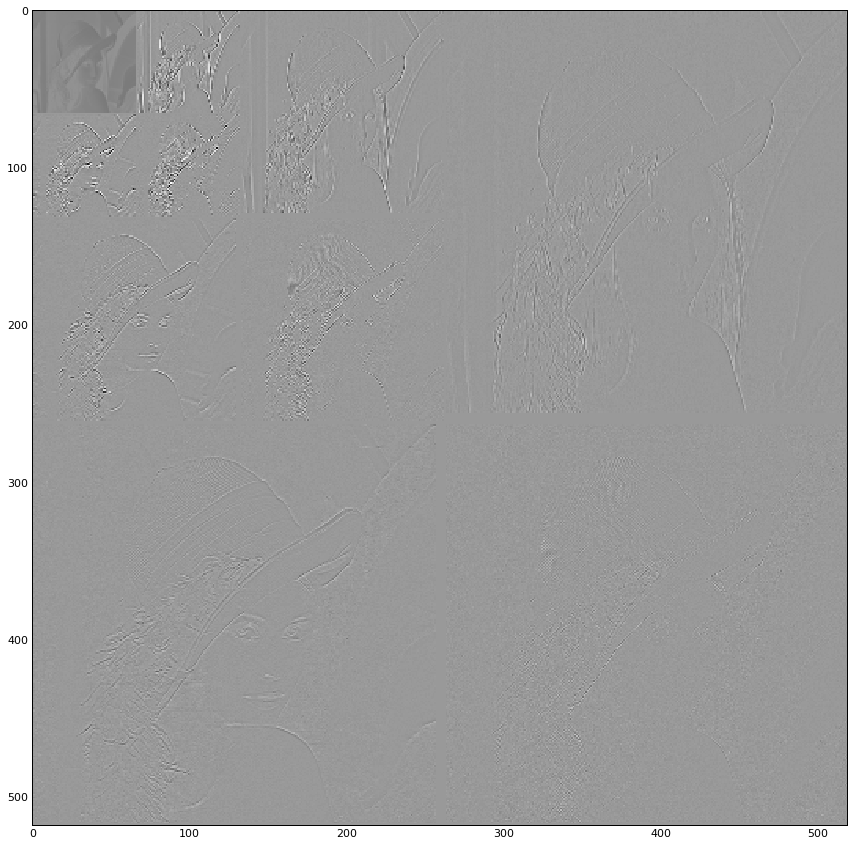

In [8]:
nwp = normwt(wp) # normalized wavelet pyramid
'''
for im in nwp:
    print(np.shape(im))
'''
arr,_ = pywt.coeffs_to_array(nwp)
#arr = (arr-np.amin(arr))/(np.amax(arr)-np.amin(arr))
#print(arr)

plt.figure(figsize=(15,15))
plt.imshow(arr,cmap='Greys')
#cv2.imwrite("wavelet.png", arr)

In [9]:
#### Steerable pyramid
s = Steerable(5)
sp = s.buildSCFpyr(imGray)
for im in sp:
    print(np.shape(im))
imGray_rec = s.reconSCFpyr(sp)

(512, 512)
(4, 512, 512)
(4, 256, 256)
(4, 128, 128)
(64, 64)


norm diff = 362.258195214


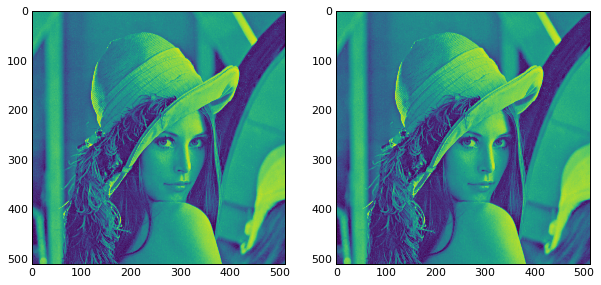

In [10]:
print('norm diff = %s' % np.linalg.norm(imGray_rec-imGray))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(imGray)
plt.subplot(122)
plt.imshow(imGray_rec)

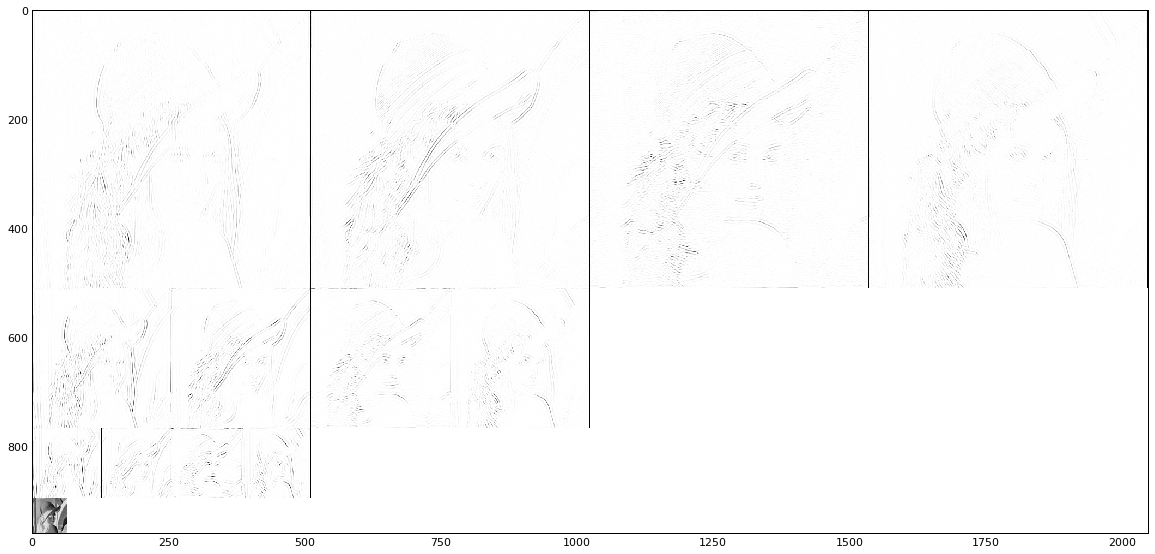

In [11]:
arr = visualize(sp)
arr = np.maximum(0,arr).astype(np.uint8)
#print(arr)

plt.figure(figsize=(20,10))
plt.imshow(arr,cMap='Greys')
#cv2.imwrite("steer.png", arr)

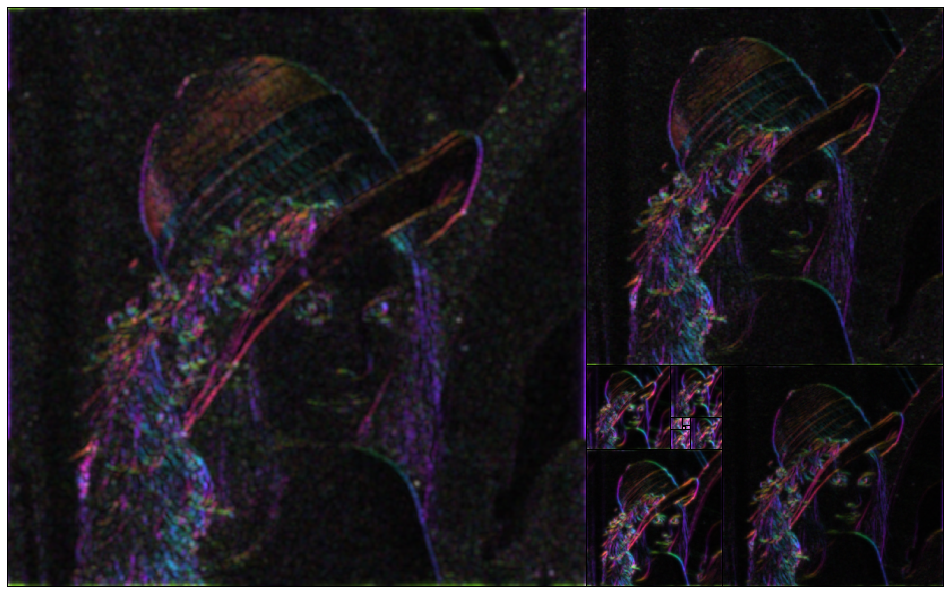

In [12]:
# Gabor, LogGabor filter (motivated by human visual system)
opts= {'vmin':0., 'vmax':1., 'interpolation':'nearest', 'origin':'upper'}

parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor.LogGabor(parameterfile)
lg.set_size(imGray)
phi = (np.sqrt(5) +1.)/2. # golden number
lg.pe.base_levels = phi
lg.init()

C = lg.linear_pyramid(imGray)
fig, axs = lg.golden_pyramid(C)